In [1]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize

# All the functions

In [2]:
#define functions

#create function that finds mena
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#creates random distributions, where the values aren't below zero, and also returns the original mean of 
#the distribution.
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
    oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

    blues = true_blues.T
    oranges = true_oranges.T
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

In [12]:
a, _, b = brownian_population()

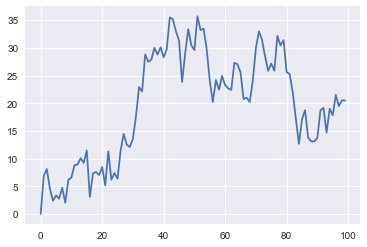

In [15]:
plt.plot(b)
plt.show()

## Find a way to create populations

In [3]:
a, mean_a, _ = brownian_population()
b, mean_b, _ = brownian_population()

if mean_a > mean_b:
    blues = np.copy(b)
    oranges = np.copy(a)
else:
    blues = np.copy(a)
    oranges = np.copy(b)
    
true_blues = np.zeros(1)
true_oranges = np.zeros(1)

for i in range(100):
    num_blues = int(blues[i])
    num_oranges = int(oranges[i])
    elements_blues = np.multiply(np.ones(num_blues),i)
    elements_oranges = np.multiply(np.ones(num_oranges), i)
    
    true_blues = np.concatenate((true_blues, elements_blues), axis=0)
    true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)
    
#determine who defaulted
blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

blues = true_blues.T
oranges = true_oranges.T

## Plot populations

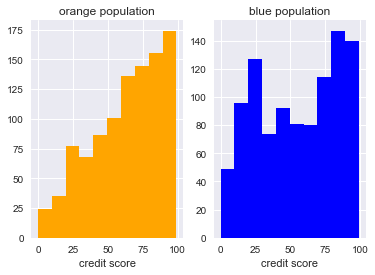

In [4]:
plt.subplot(121)
plt.hist(oranges, bins=10, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=10, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()


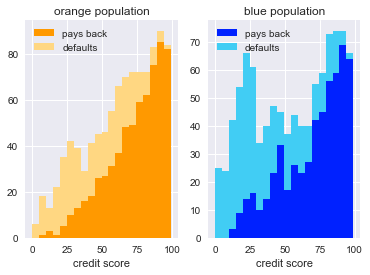

In [5]:
plt.subplot(121)
plt.hist([true_oranges[np.logical_not(oranges_who_defaulted)],true_oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([true_blues[np.logical_not(blues_who_defaulted)],true_blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

## Optimise for the first time

In [6]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  405 $


### With fairness

In [7]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3})

x_fair = solution.x

In [8]:
print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[49.39983003 58.61126864]
final guess of [49.39983003 58.61126864] got us a profit of  427 $
total credit score change for blues: 160 || total credit score change for oranges: 267


### Without fairness

In [9]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [10]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

final guess of [67.9147249  65.27859816] got us a profit of  497 $
total credit score change for blues: 202 || total credit score change for oranges: 295


# Do this all systematically

## 1. With fairness

In [11]:
num_its = 1000

profit_eq_opt = np.zeros(num_its)
credit_change_blues_eq_opt = np.zeros(num_its)
credit_change_oranges_eq_opt = np.zeros(num_its)
selection_rate_blues_eq_opt = np.zeros(num_its)
selection_rate_oranges_eq_opt = np.zeros(num_its)

population_log_blues = np.zeros((num_its, 1000))
population_log_oranges = np.zeros((num_its, 1000))

profit_no_fairness = np.zeros(num_its)
credit_change_blues_no_fairness = np.zeros(num_its)
credit_change_oranges_no_fairness = np.zeros(num_its)
selection_rate_blues_no_fairness = np.zeros(num_its)
selection_rate_oranges_no_fairness = np.zeros(num_its)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50

#optimise bank profit
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])

#impose bounds
a = (0, 100)
bounds = (a, a)

how_long_did_it_take = time.time()

for i in range(num_its):
    t = time.time()
    
    
    blues, oranges, blues_who_defaulted, oranges_who_defaulted, _, _ = create_blues_and_oranges()
    
    population_log_blues[i] = blues
    population_log_oranges[i] = oranges
    
    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1])
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3, 'maxiter': 10})

    x_fair = solution_unfair.x
    
    profit_eq_opt[i] = -to_optimise(x_fair)
    _, selection_rate_blues_eq_opt[i], credit_change_blues_eq_opt[i] = bank_profit(blues, blues_who_defaulted, x_fair[0])
    _, selection_rate_oranges_eq_opt[i], credit_change_oranges_eq_opt[i] = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
    
    
    solution_fair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_fair.x
    
    profit_no_fairness[i] = -to_optimise(x_unfair)
    _, selection_rate_blues_no_fairness[i], credit_change_blues_no_fairness[i] = bank_profit(blues, blues_who_defaulted, x_unfair[0])
    _, selection_rate_oranges_no_fairness[i], credit_change_oranges_no_fairness[i] = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
    
    
    
    if (i % 50 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")

print("This took very long to run", (time.time() - how_long_did_it_take)/60, "minutes to be exact.")

iteration 0 (which took 1.4431819915771484 seconds).
iteration 50 (which took 1.0090157985687256 seconds).
iteration 100 (which took 3.1204617023468018 seconds).
iteration 150 (which took 3.3762221336364746 seconds).
iteration 200 (which took 0.9250037670135498 seconds).
iteration 250 (which took 3.619828939437866 seconds).
iteration 300 (which took 3.512354850769043 seconds).
iteration 350 (which took 1.218224048614502 seconds).
iteration 400 (which took 1.8668849468231201 seconds).
iteration 450 (which took 1.0780878067016602 seconds).
iteration 500 (which took 1.0690500736236572 seconds).
iteration 550 (which took 3.3415770530700684 seconds).
iteration 600 (which took 4.014501094818115 seconds).
iteration 650 (which took 1.5491368770599365 seconds).
iteration 700 (which took 3.2834370136260986 seconds).
iteration 750 (which took 1.408278226852417 seconds).
iteration 800 (which took 1.3923981189727783 seconds).
iteration 850 (which took 4.029362916946411 seconds).
iteration 900 (whic

In [34]:
print(np.average(selection_rate_blues_no_fairness)/np.average(selection_rate_oranges_no_fairness))
print("is hopefully higher than")
print(np.average(selection_rate_blues_eq_opt)/np.average(selection_rate_oranges_eq_opt))

0.6345220257716513
is hopefully higher than
0.8643546061322994


263
675


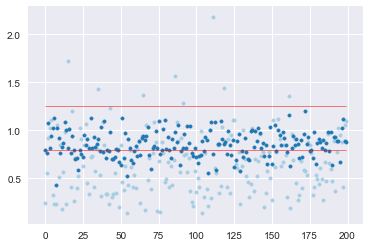

In [52]:
p_rule_no_fairness = selection_rate_blues_no_fairness/selection_rate_oranges_no_fairness
p_rule_fairness = selection_rate_blues_eq_opt/selection_rate_oranges_eq_opt
print(1000 - sum(p_rule_no_fairness > 1.25) - sum(p_rule_no_fairness < 0.8))
print(1000 - sum(p_rule_fairness > 1.25) - sum(p_rule_fairness < 0.8))
plt.scatter(np.arange(200),p_rule_no_fairness[0:200], marker = '.')
plt.scatter(np.arange(200), p_rule_fairness[0:200], marker='.')
plt.plot(np.arange(200), np.ones(200)*0.8, linewidth=0.5, color='r')
plt.plot(np.arange(200), np.ones(200)*1.25, linewidth=0.5, color='r')
plt.show()

## Plot distributions of populations under fairness and no fairness constraints

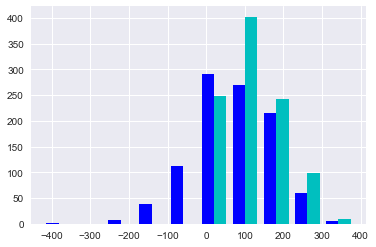

In [12]:
plt.hist((credit_change_blues_eq_opt, credit_change_blues_no_fairness), color=("b", "c"))
plt.show()

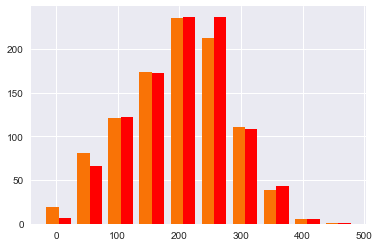

In [13]:
plt.hist((credit_change_oranges_eq_opt, credit_change_oranges_no_fairness), color=("xkcd:orange", "r"))
plt.show()

In [14]:
print("Fairness blues got", sum(credit_change_blues_eq_opt), 
      "whereas unfair blues got", sum(credit_change_blues_no_fairness))

print("Fairness oranges got", sum(credit_change_oranges_eq_opt), 
      "whereas unfair oranges got", sum(credit_change_oranges_no_fairness))

Fairness blues got 75106.0 whereas unfair blues got 118197.0
Fairness oranges got 197971.0 whereas unfair oranges got 204606.0


In [15]:
comparisons_smaller = credit_change_blues_eq_opt < credit_change_blues_no_fairness
comparisons_bigger = credit_change_blues_eq_opt > credit_change_blues_no_fairness
comparisons_equal = np.abs(credit_change_blues_eq_opt - credit_change_blues_no_fairness) < 3

# Generate pretty plots

1. What's the gap between unfair and fair classification
2. What do the distributions look like?
3. How many people default?


### 1. What's the gap between unfair and fair classification

In [16]:
average_blue = np.average(population_log_blues, axis=0)
average_orange = np.average(population_log_oranges, axis=0)
average_distance = average_orange-average_blue
average_distance.shape

(1000,)

In [17]:
frame = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                        credit_change_oranges_eq_opt.reshape(1000,1), 
                        credit_change_blues_no_fairness.reshape(1000,1), 
                        credit_change_oranges_no_fairness.reshape(1000,1)), axis=1)



change_for_blues = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                                   credit_change_blues_no_fairness.reshape(1000,1),
                                   average_distance.reshape(1000,1)), axis=1)

credit_changes_blue = pd.DataFrame(change_for_blues)
credit_changes_blue.columns = ["blue with equal opportunity",
                               "blue with no constraints",
                               "average distance"]


credit_changes = pd.DataFrame(frame)
credit_changes.columns = ["blue with equal opportunity", 
                          "orange with equal opportunity", 
                          "blue with no constraint", 
                          "oranges with no constraint"]

In [18]:
credit_changes_blue["distance"] = credit_changes_blue["blue with no constraints"] - credit_changes_blue["blue with equal opportunity"]

credit_changes_blue = credit_changes_blue.sort_values("distance", ascending=False)

credit_changes_blue["sorted index"] = np.arange(1000)
credit_changes_blue.head()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
949,-422.0,72.0,4.784,494.0,0
346,-369.0,124.0,15.418,493.0,1
37,-238.0,96.0,3.815,334.0,2
74,-220.0,72.0,6.252,292.0,3
324,-226.0,48.0,15.105,274.0,4


In [19]:
sum(credit_changes_blue["average distance"] < 0)

0

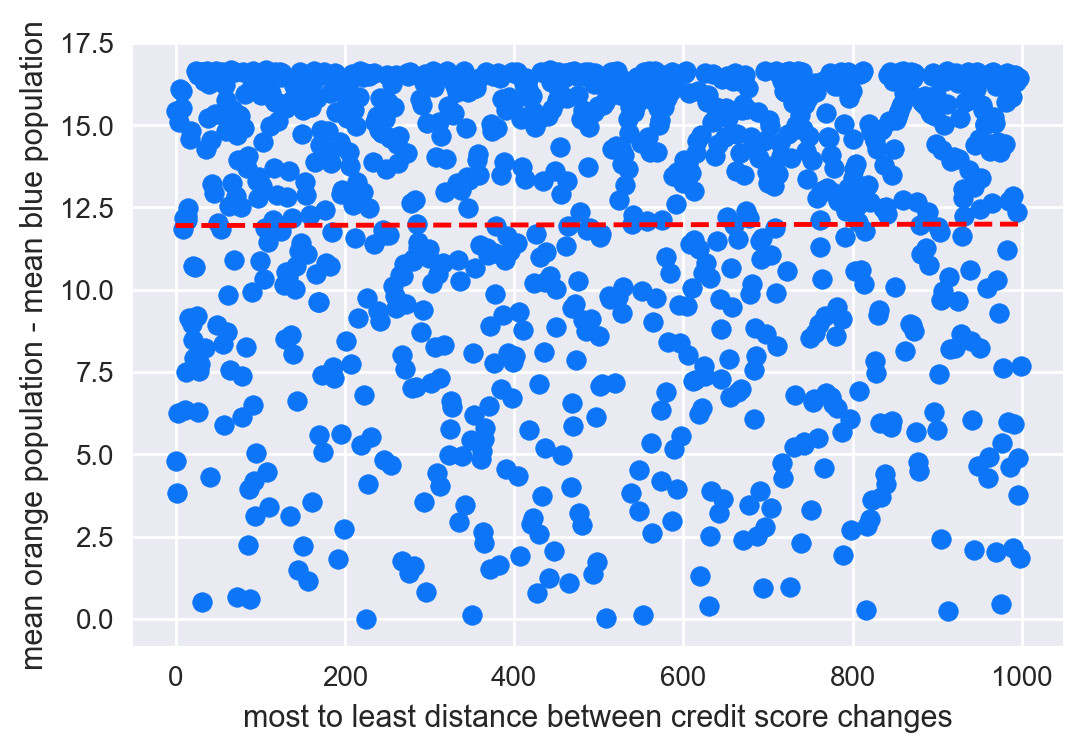

In [20]:
plt.figure(dpi=200)

credit_changes_blue_sub = credit_changes_blue.sample(1000)

trendline = np.polyfit(credit_changes_blue_sub["sorted index"], credit_changes_blue_sub["average distance"], 1)
p = np.poly1d(trendline)
plt.scatter(credit_changes_blue_sub["sorted index"],credit_changes_blue_sub["average distance"], c='xkcd:deep sky blue')
plt.plot(credit_changes_blue["sorted index"], p(credit_changes_blue["sorted index"]), "r--")
plt.ylabel("mean orange population - mean blue population")
plt.xlabel("most to least distance between credit score changes")
plt.savefig("plots/big_sim/GOOD_worse_doesnt_help.png")
plt.show()

In [21]:
credit_changes_blue.tail()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
947,189.0,165.0,4.896,-24.0,995
964,237.0,212.0,3.766,-25.0,996
433,117.0,74.0,16.442,-43.0,997
15,190.0,128.0,1.856,-62.0,998
901,133.0,57.0,7.678,-76.0,999


In [22]:
print(credit_changes_blue.index[-2])
distance_far = 0
distance_close = 0
distance_medium = 0
for i in range(20):
    index = credit_changes_blue.index[i]
    distance_far += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])

for i in range(20):
    index = credit_changes_blue.index[-i]
    distance_close += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
    
    
for i in range(20):
    index = credit_changes_blue.index[i+490]
    distance_medium +=np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
print("far=",distance_far/20, "|| close=",distance_close/20, "|| medium=", distance_medium/20)

15
far= 22.529850000000003 || close= 9.130749999999999 || medium= 13.73545


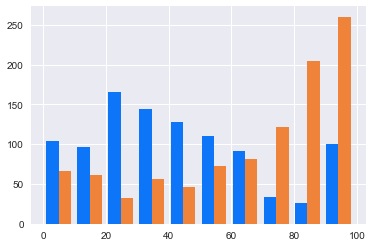

In [23]:
plt.hist((population_log_blues[473], population_log_oranges[473]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

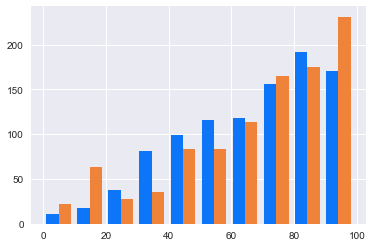

In [24]:
plt.hist((population_log_blues[431], population_log_oranges[431]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

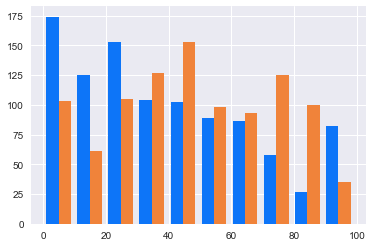

In [25]:
plt.hist((population_log_blues[816], population_log_oranges[816]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

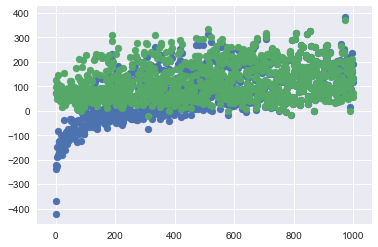

In [26]:
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with equal opportunity"])
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with no constraints"])
plt.show()

In [27]:
print(sum(credit_changes_blue["distance"] > 1))
print(sum(credit_changes_blue["distance"] < -1))

small = credit_changes_blue["distance"] <= 1
butbig = credit_changes_blue["distance"] >= -1
medium = np.logical_and(small, butbig)
print(sum(medium))

783
93
124


/anaconda/envs/mlp/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x113ddb630>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


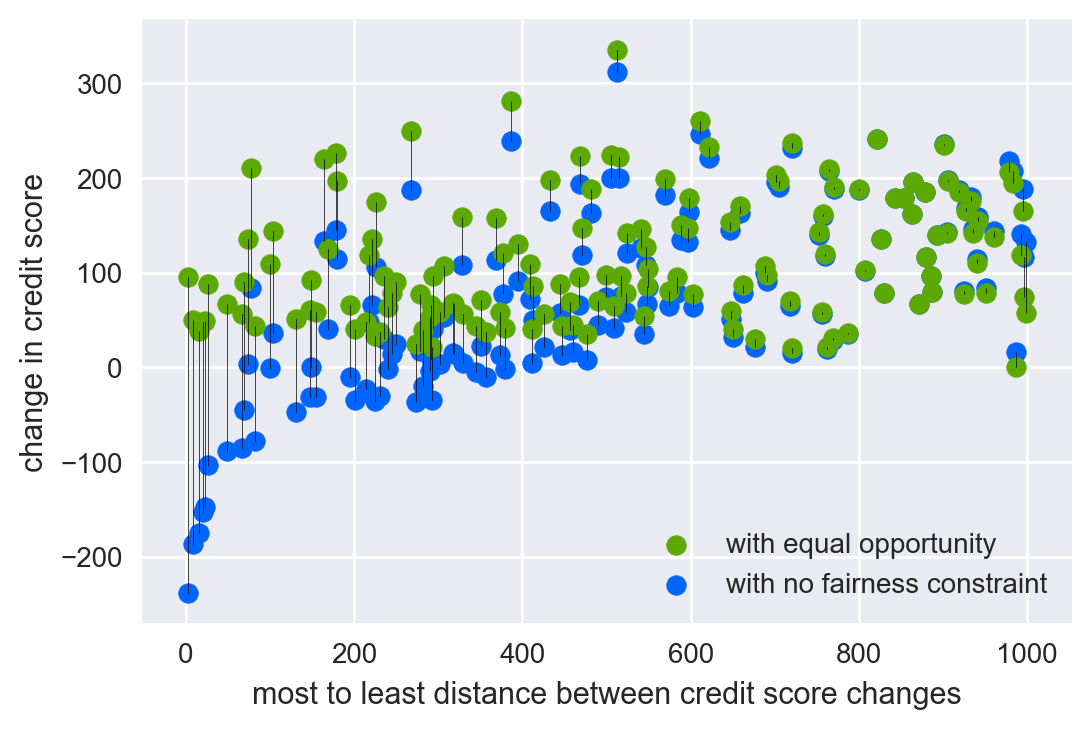

In [28]:
subsampled_credit_changes = credit_changes_blue.sample(150)

average_no_fairness = np.average(subsampled_credit_changes["blue with no constraints"])
average_eq_opt = np.average(subsampled_credit_changes["blue with equal opportunity"])
# plt.figure(figsize=(4,3), dpi=150) 
plt.figure(dpi=200)

# plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"], 
#             c="xkcd:bright blue")
# plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with no constraints"], 
#             c='xkcd:leaf green')

plt.ylabel("change in credit score")
plt.xlabel("most to least distance between credit score changes")
# plt.legend(["with equal opportunity", "with no fairness constraint"])
           
for i in range(len(subsampled_credit_changes.values)):
    plotdistances = plt.plot(subsampled_credit_changes['sorted index'].values[i]*np.ones((2, 1)),
                             [subsampled_credit_changes['blue with equal opportunity'].values[i], 
                              subsampled_credit_changes['blue with no constraints'].values[i]], 
                             c='black', linewidth=0.25)

scatterblue = plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"], 
            c="xkcd:bright blue")
scattergreen = plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with no constraints"], 
            c='xkcd:leaf green')

plt.legend((scattergreen, scatterblue, plotdistances), ("with equal opportunity", "with no fairness constraint", "else"))

plt.savefig("plots/big_sim/distance_between_score_changes.png")
plt.show()

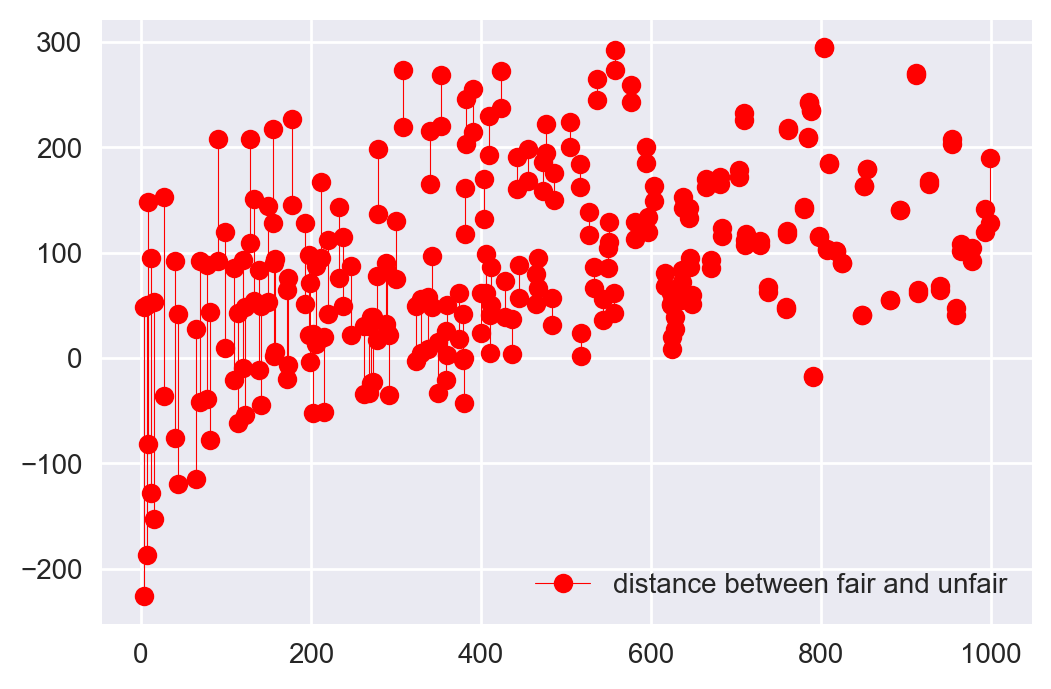

In [29]:
subsampled_credit_changes = credit_changes_blue.sample(150)

average_no_fairness = np.average(subsampled_credit_changes["blue with no constraints"])
average_eq_opt = np.average(subsampled_credit_changes["blue with equal opportunity"])
# plt.figure(figsize=(4,3), dpi=150) 
plt.figure(dpi=200)

# plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"])
# plt.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with no constraints"])

# plt.ylabel("change in credit score")
# plt.xlabel("most to least distance between credit score changes")


for i in range(len(subsampled_credit_changes.values)):
    plt.plot(subsampled_credit_changes['sorted index'].values[i]*np.ones((2, 1)),
             [subsampled_credit_changes['blue with equal opportunity'].values[i], 
              subsampled_credit_changes['blue with no constraints'].values[i]], 
             'ro-', linewidth=0.4)

plt.legend(["distance between fair and unfair"])

plt.savefig("plots/big_sim/distance_between_score_changes.png")
plt.show()

## 2. What do the distributions look like?

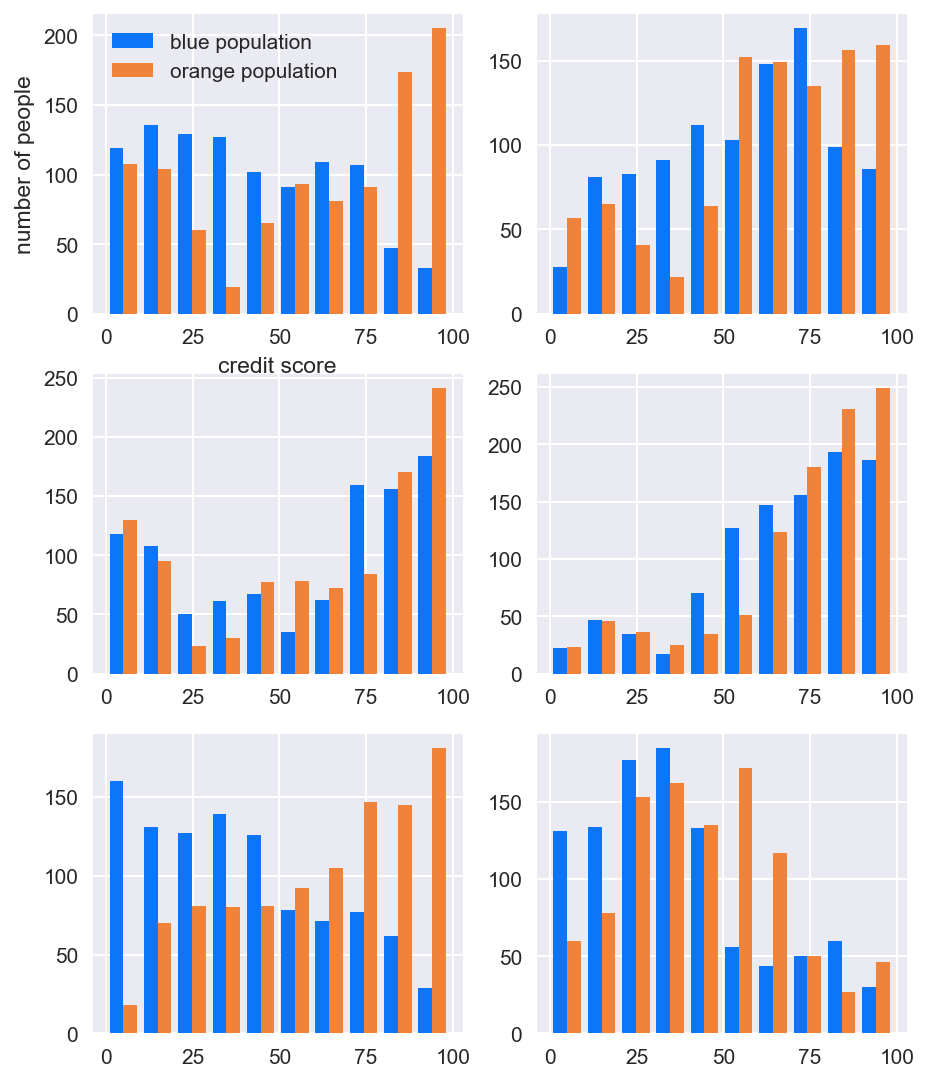

In [30]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")
for i in range(6):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        plt.legend(("blue population", "orange population"))
        

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

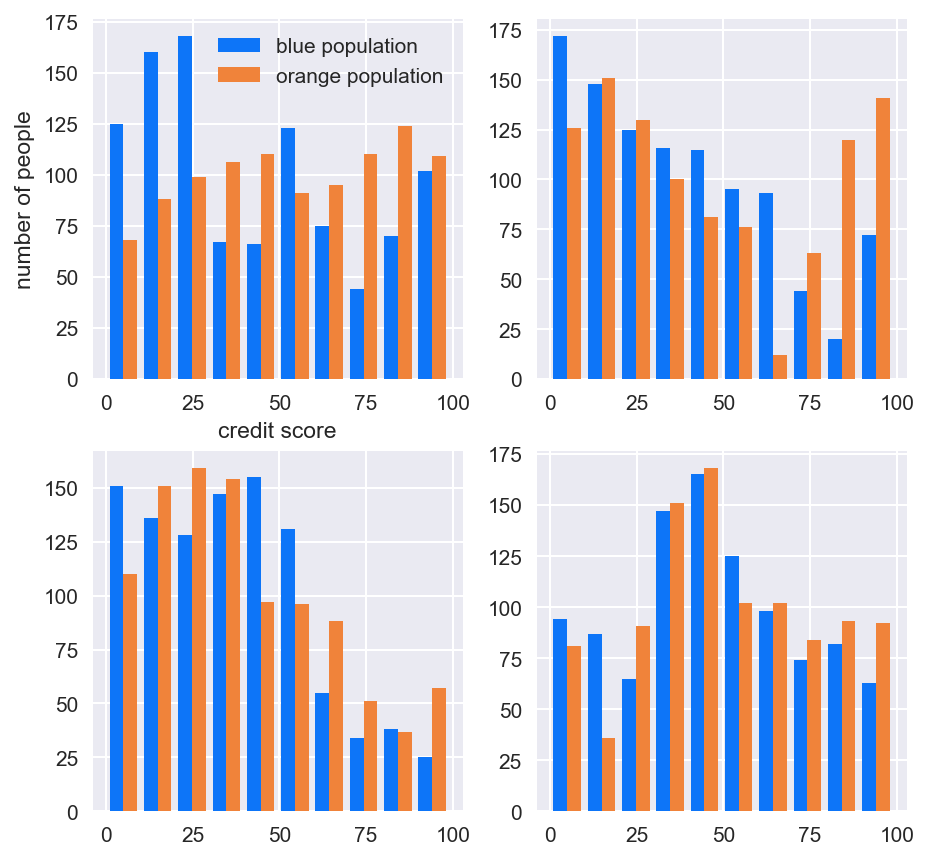

In [31]:
plt.figure(figsize=(7,7), dpi=150)       
sns.set_palette("Paired")
for i in range(4):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(2, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        plt.legend(("blue population", "orange population"))

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

### 3. How many people default?

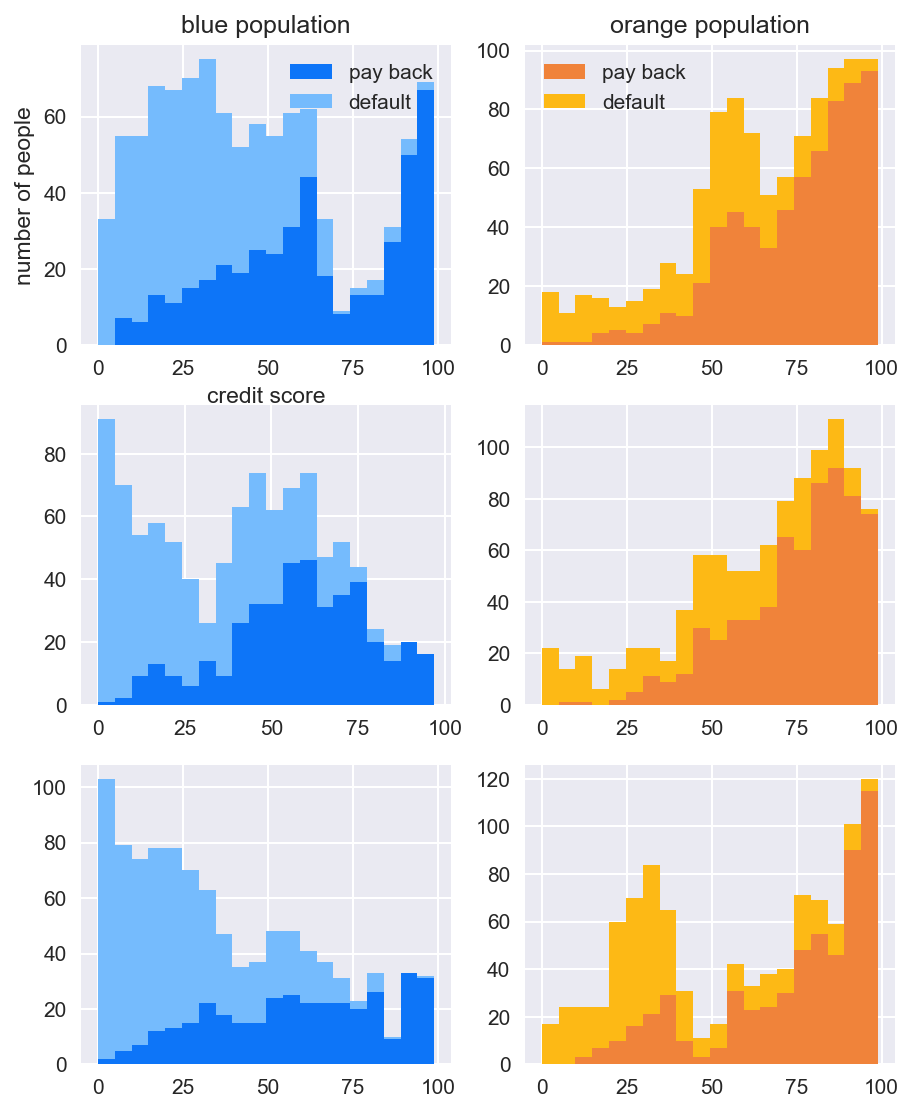

In [32]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")
for i in range(6):
    a, b, c, d, _, _ = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)
    
    if(i%2==0):
        plt.hist([a[np.logical_not(c)],a[c]], 
                 stacked=True, bins=20, color=("xkcd:deep sky blue", "xkcd:sky blue"))
    if(i%2==1):
        plt.hist([b[np.logical_not(d)],b[d]], 
                 stacked=True, bins=20, color=("xkcd:dusty orange", "xkcd:orangey yellow"))
    
    if(i==1):

        plt.legend(("pay back", "default"))
        plt.title("orange population")
        
    if(i==0):
        plt.legend(("pay back", "default"))
        plt.title("blue population")
        plt.ylabel("number of people")
        plt.xlabel("credit score")        
    

plt.savefig("plots/big_sim/defaults_no_defaults.png")
plt.show()

In [33]:
print(1+1)

2
